In [1]:
# Basic Data Handling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Evaluation
import matplotlib.pyplot as plt

# Saving Pipeline
import joblib

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load dataset
df = pd.read_csv("lab_11_bridge_data.csv")

# Preview dataset
df.head()

,Bridge_ID,Span_ft,Deck_Width_ft,Age_Years,Num_Lanes,Material,Condition_Rating,Max_Load_Tons
0,B001,403,25,77,4,Steel,5,249
1,B002,511,34,15,6,Composite,2,233
2,B003,225,20,10,1,Composite,2,102
3,B004,380,29,26,1,Steel,1,100
4,B005,565,20,88,5,Steel,1,206


In [3]:
# Check for missing values
print(df.isnull().sum())

# Describe numerical features
print(df.describe())

# Check categorical variables
print(df['Material'].value_counts())

Bridge_ID           0
Span_ft             0
Deck_Width_ft       0
Age_Years           0
Num_Lanes           0
Material            0
Condition_Rating    0
Max_Load_Tons       0
dtype: int64
          Span_ft  Deck_Width_ft   Age_Years   Num_Lanes  Condition_Rating  \
count  500.000000     500.000000  500.000000  500.000000        500.000000   
mean   347.268000      40.162000   53.218000    3.556000          2.950000   
std    145.665759      11.835197   27.540578    1.707834          1.418282   
min    100.000000      20.000000    5.000000    1.000000          1.000000   
25%    213.250000      29.000000   30.000000    2.000000          2.000000   
50%    356.500000      41.000000   53.000000    4.000000          3.000000   
75%    467.250000      50.000000   77.000000    5.000000          4.000000   
max    599.000000      60.000000  100.000000    6.000000          5.000000   

       Max_Load_Tons  
count     500.000000  
mean      177.366000  
std        44.173642  
min       100.00

In [4]:
# Drop Bridge_ID since it's not useful for prediction
df = df.drop(columns=['Bridge_ID'])

# Define feature and target
X = df.drop(columns=['Max_Load_Tons'])
y = df['Max_Load_Tons']

# Identify categorical and numerical columns
categorical_cols = ['Material']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


['preprocessing_pipeline.pkl']

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Save preprocessing pipeline
joblib.dump(preprocessor, 'preprocessing_pipeline.pkl')

['preprocessing_pipeline.pkl']

In [6]:
# Define model architecture
model = models.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1)  # Linear output for regression
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [7]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 31807.4922 - mae: 172.6759 - val_loss: 33010.9883 - val_mae: 176.8022
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32686.5977 - mae: 175.0516 - val_loss: 32810.0547 - val_mae: 176.2385
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32000.0664 - mae: 172.9794 - val_loss: 32561.0527 - val_mae: 175.5372
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32090.1152 - mae: 173.1669 - val_loss: 32246.3086 - val_mae: 174.6462
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32588.2520 - mae: 174.8115 - val_loss: 31836.0215 - val_mae: 173.4766
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32041.1172 - mae: 173.3730 - val_loss: 31313.3594 - val_mae: 171.9751
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30361.6328 - mae: 168.4975 - val_loss: 30649.1602 - val_mae: 170.0458
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29954.9004 - mae: 166.9443 - val_loss

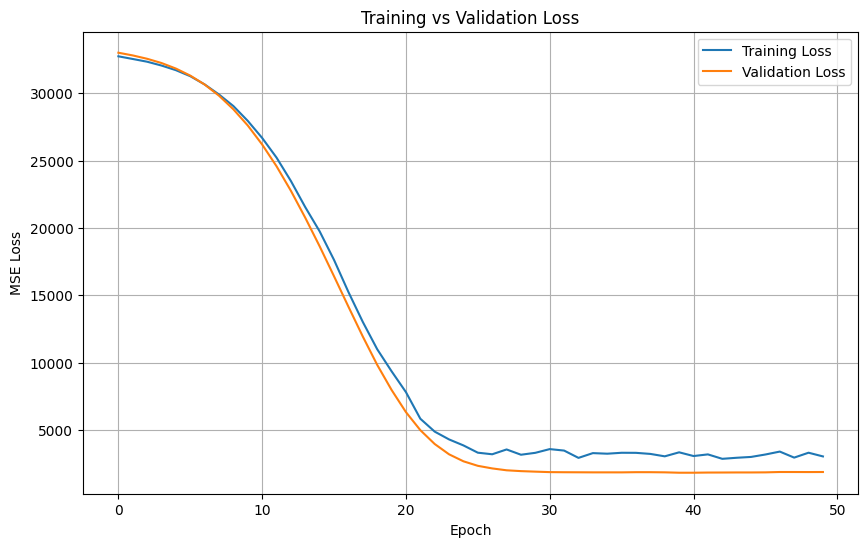

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
test_loss, test_mae = model.evaluate(X_test_processed, y_test)
print(f"Test MAE: {test_mae:.2f} tons")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1822.5394 - mae: 35.5734 
Test MAE: 37.36 tons


In [11]:
# Save trained model
model.save("tf_bridge_model.keras")